In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

/home/toledo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/toledo/deeplearningWithPython/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [3]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 521us/step - loss: 0.6158 - acc: 0.6515 - val_loss: 0.4396 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 1s 331us/step - loss: 0.4273 - acc: 0.8030 - val_loss: 0.3681 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 1s 326us/step - loss: 0.3542 - acc: 0.8550 - val_loss: 0.3330 - val_acc: 0.8660
Epoch 4/30
2000/2000 [==============================] - 1s 328us/step - loss: 0.3203 - acc: 0.8635 - val_loss: 0.2967 - val_acc: 0.8970
Epoch 5/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.2789 - acc: 0.8845 - val_loss: 0.2810 - val_acc: 0.8970
Epoch 6/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.2699 - acc: 0.8900 - val_loss: 0.2774 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 330us/step - loss: 0.2444 - acc: 0.9070 - val_loss: 0.2630 - val_acc: 0.8990


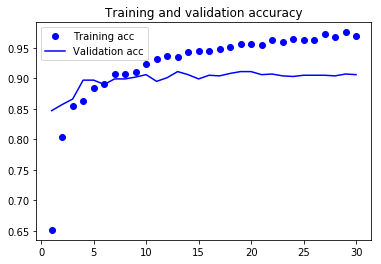

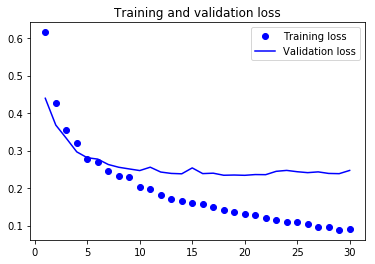

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
# adding a densely connected classifier on top of the conv_base

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 22s 218ms/step - loss: 0.5980 - acc: 0.6965 - val_loss: 0.4584 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4919 - acc: 0.7785 - val_loss: 0.3802 - val_acc: 0.8480
Epoch 3/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4292 - acc: 0.8075 - val_loss: 0.3364 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 20s 203ms/step - loss: 0.4010 - acc: 0.8270 - val_loss: 0.3168 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3795 - acc: 0.8395 - val_loss: 0.2977 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3796 - acc: 0.8200 - val_loss: 0.2902 - val_acc: 0.8780
Epoch 7/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3605 - acc: 0.8385 - val_lo

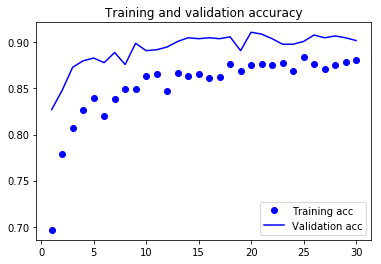

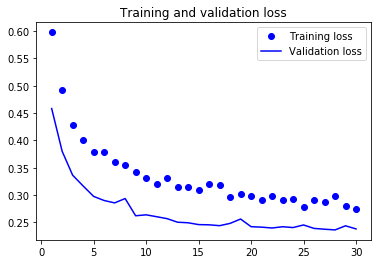

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# fine-tune network

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = True if set_trainable else False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 243ms/step - loss: 0.2969 - acc: 0.8815 - val_loss: 0.2249 - val_acc: 0.9070
Epoch 2/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2509 - acc: 0.8970 - val_loss: 0.2540 - val_acc: 0.8990
Epoch 3/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2396 - acc: 0.8900 - val_loss: 0.2307 - val_acc: 0.9070
Epoch 4/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2178 - acc: 0.9065 - val_loss: 0.1878 - val_acc: 0.9330
Epoch 5/100
100/100 [==============================] - 23s 230ms/step - loss: 0.2003 - acc: 0.9095 - val_loss: 0.1935 - val_acc: 0.9140
Epoch 6/100
100/100 [==============================] - 23s 230ms/step - loss: 0.1988 - acc: 0.9190 - val_loss: 0.1978 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 23s 230ms/step - loss: 0.1915 - acc: 0.9150 - val_loss: 0.1795 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0375 - acc: 0.9875 - val_loss: 0.2065 - val_acc: 0.9380
Epoch 62/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0224 - acc: 0.9925 - val_loss: 0.2370 - val_acc: 0.9380
Epoch 63/100
100/100 [==============================] - 23s 229ms/step - loss: 0.0268 - acc: 0.9925 - val_loss: 0.2627 - val_acc: 0.9340
Epoch 64/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0226 - acc: 0.9920 - val_loss: 0.3077 - val_acc: 0.9310
Epoch 65/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0303 - acc: 0.9890 - val_loss: 0.2628 - val_acc: 0.9390
Epoch 66/100
100/100 [==============================] - 23s 229ms/step - loss: 0.0232 - acc: 0.9930 - val_loss: 0.2879 - val_acc: 0.9330
Epoch 67/100
100/100 [==============================] - 23s 230ms/step - loss: 0.0363 - acc: 0.9905 - val_loss: 0.2277 - val_acc: 0.9440
Epoch 68/100
100/100 [===================

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)